# Flower Classification Swin Large with External Data

This notebook is designed to show how Swin Large transformer model can be used with TPU.  It is based on my [earlier notebook](https://www.kaggle.com/code/atamazian/fc-ensemble-external-data-effnet-densenet), and it uses [external data](https://www.kaggle.com/kirillblinov/tf-flower-photo-tfrec) to increase model's accuracy.

Have any suggestions? Feel free to comment.

**<span style="color:red">If you liked this kernel, please don't forget to upvote it!</span>**

In [1]:
!pip install -qU wandb

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
elegy 0.8.6 requires wandb<0.13.0,>=0.12.10, but you have wandb 0.15.12 which is incompatible.

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
!git clone https://github.com/rishigami/Swin-Transformer-TF
    
import sys
sys.path.append('/kaggle/working/Swin-Transformer-TF')

Cloning into 'Swin-Transformer-TF'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 44 (delta 15), reused 7 (delta 7), pack-reused 26
Receiving objects: 100% (44/44), 15.90 KiB | 15.90 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [3]:
import math, re, os, random
import numpy as np
import pandas as pd
import wandb
from wandb.integration.keras import WandbCallback
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, precision_score, \
                            recall_score, confusion_matrix

import tensorflow as tf
from tensorflow_addons.metrics import F1Score
from tensorflow.keras import layers as L
from tensorflow.keras import callbacks
from swintransformer import SwinTransformer

print("TF version " + tf.__version__)

D1104 12:47:27.738609149      14 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D1104 12:47:27.738630714      14 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D1104 12:47:27.738634152      14 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D1104 12:47:27.738636678      14 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D1104 12:47:27.738639001      14 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D1104 12:47:27.738641426      14 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D1104 12:47:27.738644595      14 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D1104 12:47:27.

TF version 2.12.0


/usr/local/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


We will use wandb for logging purposes. If you want to write logging results to your Wandb account, use Add-ons -> Secrets to set `wandb_key` variable to your Wandb API key.

In [4]:
try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret('wandb_key')
    wandb.login(key=api_key)
    anonymous = None
except:
    wandb.login(anonymous='must')
    print('To use your W&B account,\nGo to Add-ons -> Secrets and provide your \
           W&B access token. Use the Label name as WANDB. \nGet your W&B access \
           token from here: https://wandb.ai/authorize')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## TPU detection

In [5]:
AUTO = tf.data.AUTOTUNE

def get_strategy():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
    except ValueError:
        strategy = tf.distribute.get_strategy()
    return strategy


# Detect hardware, return appropriate distribution strategy
strategy = get_strategy()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


## Configuration

In [6]:
SEED = 42

IMAGE_SIZE = [224, 224]
EPOCHS = 30
BATCH_SIZE = 32 * strategy.num_replicas_in_sync

SWIN_TYPE = 'large'

In [7]:
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    
set_seed(SEED)

## Data access and classes

TPUs read data directly from Google Cloud Storage (GCS), so we need to copy the dataset to a GCS bucket co-located with the TPU. To do that, pass the name of a specific dataset to the get_gcs_path function. The name of the dataset is the name of the directory it is mounted in. 

In [8]:
DS_PATH = '/kaggle/input/tpu-getting-started'
DS_PATH_EXT = '/kaggle/input/tf-flower-photo-tfrec'

DATA_PATH_SELECT = { # available image sizes
    192: DS_PATH + '/tfrecords-jpeg-192x192',
    224: DS_PATH + '/tfrecords-jpeg-224x224',
    331: DS_PATH + '/tfrecords-jpeg-331x331',
    512: DS_PATH + '/tfrecords-jpeg-512x512'
}
DATA_PATH = DATA_PATH_SELECT[IMAGE_SIZE[0]]

# External data
DATA_PATH_SELECT_EXT = {
    192: '/tfrecords-jpeg-192x192',
    224: '/tfrecords-jpeg-224x224',
    331: '/tfrecords-jpeg-331x331',
    512: '/tfrecords-jpeg-512x512'
}
DATA_PATH_EXT = DATA_PATH_SELECT_EXT[IMAGE_SIZE[0]]

IMAGENET_FILES = tf.io.gfile.glob(DS_PATH_EXT + '/imagenet' + DATA_PATH_EXT + '/*.tfrec')
INATURELIST_FILES = tf.io.gfile.glob(DS_PATH_EXT + '/inaturalist' + DATA_PATH_EXT + '/*.tfrec')
OPENIMAGE_FILES = tf.io.gfile.glob(DS_PATH_EXT + '/openimage' + DATA_PATH_EXT + '/*.tfrec')
OXFORD_FILES = tf.io.gfile.glob(DS_PATH_EXT + '/oxford_102' + DATA_PATH_EXT + '/*.tfrec')
TENSORFLOW_FILES = tf.io.gfile.glob(DS_PATH_EXT + '/tf_flowers' + DATA_PATH_EXT + '/*.tfrec')

ADDITIONAL_TRAINING_FILENAMES = IMAGENET_FILES + INATURELIST_FILES + OPENIMAGE_FILES + OXFORD_FILES + TENSORFLOW_FILES  

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                          # 100 - 102

TRAINING_FILENAMES = tf.io.gfile.glob(DATA_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(DATA_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(DATA_PATH + '/test/*.tfrec') # predictions on this dataset should be submitted for the competition 

TRAINING_FILENAMES = TRAINING_FILENAMES + ADDITIONAL_TRAINING_FILENAMES

## Visualization functions

A set of functions to visualize data.

In [9]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

# Random erasing (blockout) augmentation

In [10]:
# https://www.kaggle.com/tusharkendre/tpu-flowers
def random_erasing(img, sl=0.1, sh=0.2, rl=0.4, p=0.3):
    h = tf.shape(img)[0]
    w = tf.shape(img)[1]
    c = tf.shape(img)[2]
    origin_area = tf.cast(h*w, tf.float32)

    e_size_l = tf.cast(tf.round(tf.sqrt(origin_area * sl * rl)), tf.int32)
    e_size_h = tf.cast(tf.round(tf.sqrt(origin_area * sh / rl)), tf.int32)

    e_height_h = tf.minimum(e_size_h, h)
    e_width_h = tf.minimum(e_size_h, w)

    erase_height = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_height_h, dtype=tf.int32)
    erase_width = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_width_h, dtype=tf.int32)

    erase_area = tf.zeros(shape=[erase_height, erase_width, c])
    erase_area = tf.cast(erase_area, tf.uint8)

    pad_h = h - erase_height
    pad_top = tf.random.uniform(shape=[], minval=0, maxval=pad_h, dtype=tf.int32)
    pad_bottom = pad_h - pad_top

    pad_w = w - erase_width
    pad_left = tf.random.uniform(shape=[], minval=0, maxval=pad_w, dtype=tf.int32)
    pad_right = pad_w - pad_left

    erase_mask = tf.pad([erase_area], [[0,0],[pad_top, pad_bottom], [pad_left, pad_right], [0,0]], constant_values=1)
    erase_mask = tf.squeeze(erase_mask, axis=0)
    erased_img = tf.multiply(tf.cast(img,tf.float32), tf.cast(erase_mask, tf.float32))

    return tf.cond(tf.random.uniform([], 0, 1) > p, lambda: tf.cast(img, img.dtype), lambda:  tf.cast(erased_img, img.dtype))

## Dataset functions

In [11]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def onehot(image,label):
    return image,tf.one_hot(label, len(CLASSES))

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = random_erasing(image)
    return image, label

def data_hflip(image, idnum):
    image = tf.image.flip_left_right(image)
    return image, idnum

def get_training_dataset(do_onehot=False):
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    if do_onehot:
        dataset = dataset.map(onehot, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048, reshuffle_each_iteration=True)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False, do_onehot=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    if do_onehot:
        dataset = dataset.map(onehot, num_parallel_calls=AUTO)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False, augmented=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    if augmented:
        dataset = dataset.map(data_hflip, num_parallel_calls=AUTO)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print(f'Dataset: {NUM_TRAINING_IMAGES} training images, {NUM_VALIDATION_IMAGES} validation images, {NUM_TEST_IMAGES} unlabeled test images')

Dataset: 68094 training images, 3712 validation images, 7382 unlabeled test images


## Dataset visualizations

In [12]:
# data dump
print("Training data shapes:")
for image, label in get_training_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())
print("Validation data shapes:")
for image, label in get_validation_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Validation data label examples:", label.numpy())
print("Test data shapes:")
for image, idnum in get_test_dataset().take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test data IDs:", idnum.numpy().astype('U')) # U=unicode string

Training data shapes:
(256, 224, 224, 3) (256,)
(256, 224, 224, 3) (256,)
(256, 224, 224, 3) (256,)
Training data label examples: [ 68  13 103 ...   0  25  30]
Validation data shapes:
(256, 224, 224, 3) (256,)
(256, 224, 224, 3) (256,)
(256, 224, 224, 3) (256,)
Validation data label examples: [58 77 29 ... 95 30 91]
Test data shapes:
(256, 224, 224, 3) (256,)
(256, 224, 224, 3) (256,)
(256, 224, 224, 3) (256,)
Test data IDs: ['57c754d1c' '1a7463151' '533d4492a' ... 'affce3819' '3149540a2' '08a1c14db']


In [13]:
# Peek at training data
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)

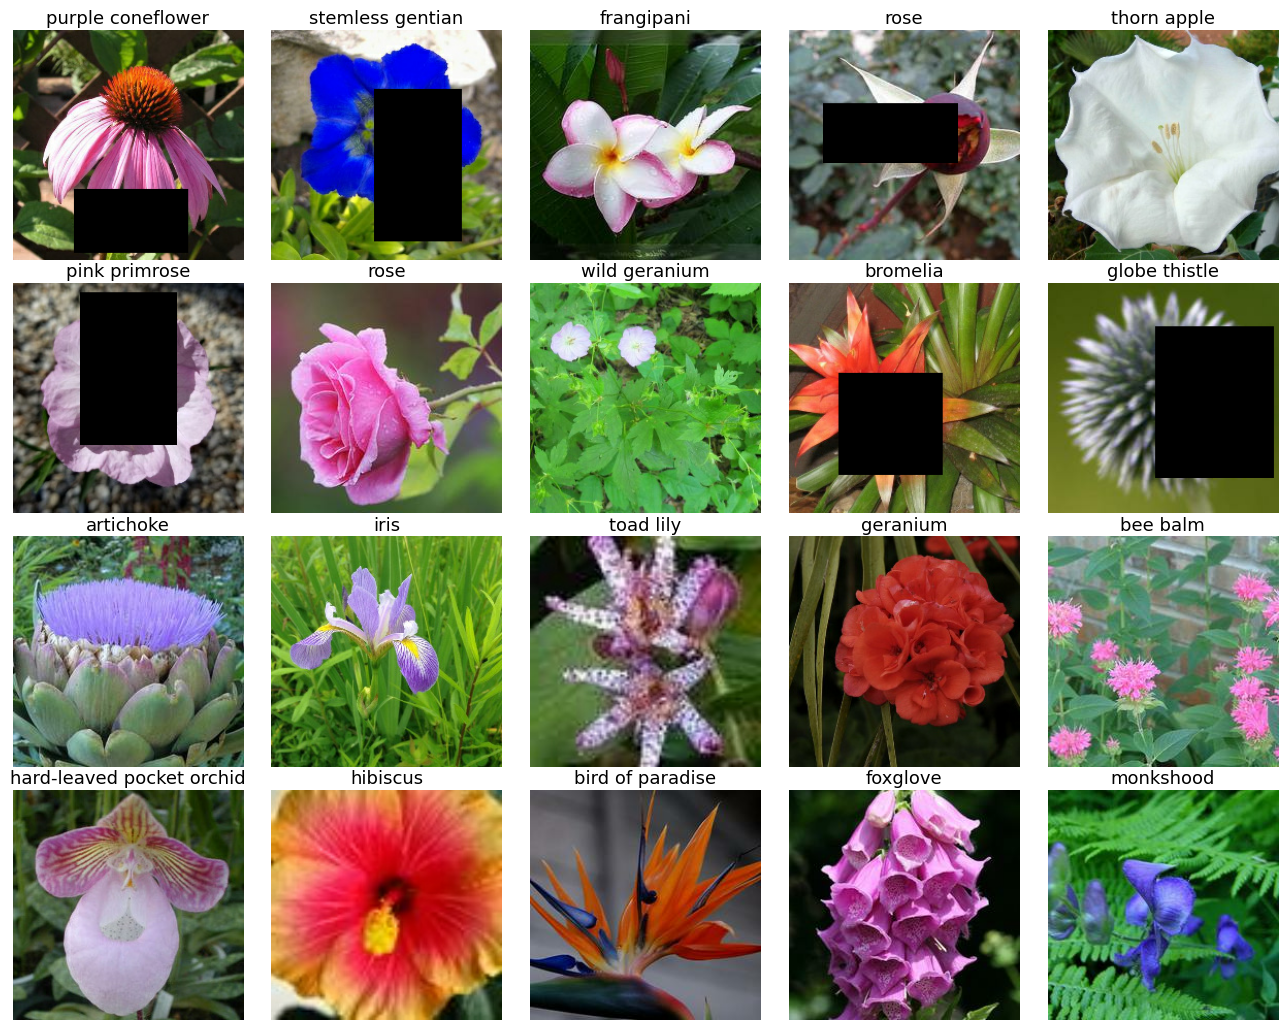

In [14]:
# run this cell again for next set of images
display_batch_of_images(next(train_batch))

In [15]:
# peer at test data
test_dataset = get_test_dataset()
test_dataset = test_dataset.unbatch().batch(20)
test_batch = iter(test_dataset)

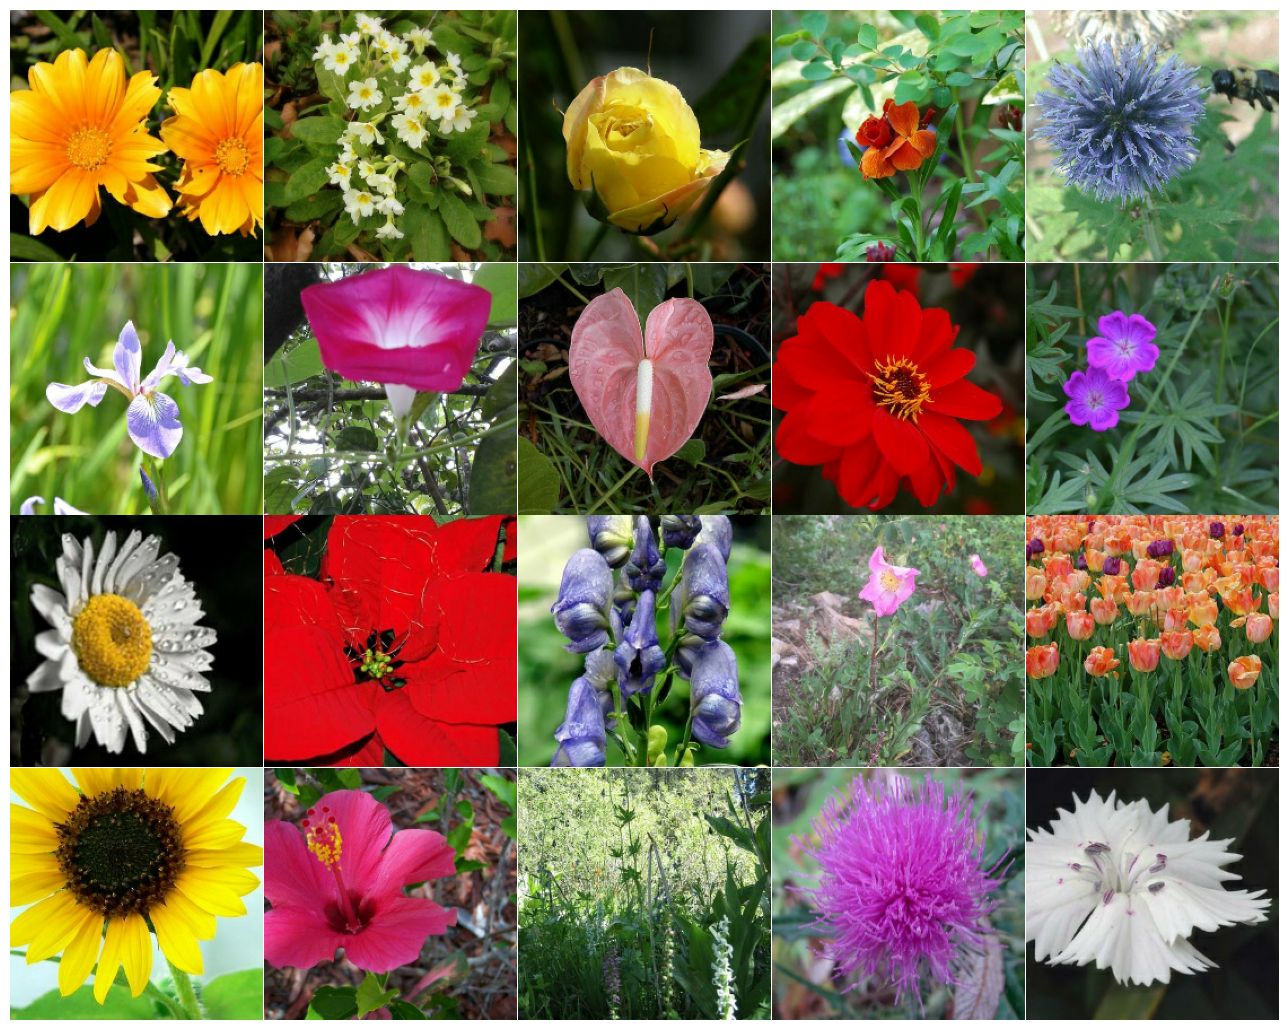

In [16]:
# run this cell again for next set of images
display_batch_of_images(next(test_batch))

## Define and train the model

### Custom LR scheduler

In [17]:
# Learning rate schedule for TPU, GPU and CPU.
# Using an LR ramp up because fine-tuning a pre-trained model.
# Starting with a high LR would break the pre-trained weights.
def get_lr_callback(plot_schedule=False):
    LR_START = 0.00001
    LR_MAX = 0.00005 * strategy.num_replicas_in_sync
    LR_MIN = 0.00001
    LR_RAMPUP_EPOCHS = 5
    LR_SUSTAIN_EPOCHS = 0
    LR_EXP_DECAY = .8

    def lrfn(epoch):
        if epoch < LR_RAMPUP_EPOCHS:
            lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
        elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
            lr = LR_MAX
        else:
            lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
        return lr
    
    if plot_schedule:
        rng = [i for i in range(25 if EPOCHS < 25 else EPOCHS)]
        y = [lrfn(x) for x in rng]
        plt.plot(rng, y)

    return callbacks.LearningRateScheduler(lrfn, verbose=0)

In [18]:
def load_and_fit_model(print_summary=False):
    with strategy.scope():
        model = tf.keras.Sequential([
            SwinTransformer(f'swin_{SWIN_TYPE}_{IMAGE_SIZE[0]}', 
                                         include_top=False, 
                                         pretrained=True),
            L.Dense(len(CLASSES), activation='softmax')
        ])
        
        model.compile(
            optimizer='adam',
            loss = 'categorical_crossentropy',
            metrics=[F1Score(len(CLASSES), average='macro')]
        )

    if print_summary:
        model.summary()
        
    os.makedirs('checkpoints', exist_ok=True)
    
    lr_callback = get_lr_callback()
    chk_callback = callbacks.ModelCheckpoint(f'checkpoints/swin_{SWIN_TYPE}_best',
                     save_weights_only=True, monitor='val_f1_score',
                     mode='max', save_best_only=True, verbose=1)
    
    wandb.init(project='flower-classification-tpu-public', 
               name='swin_large_v25',
               job_type='train', 
               reinit=True)
    log_callback = WandbCallback(
        monitor='val_f1_score',
        mode='max',
        save_model=False
    )

    _ = model.fit(get_training_dataset(do_onehot=True), 
                  steps_per_epoch=STEPS_PER_EPOCH, 
                  epochs=EPOCHS, 
                  validation_data=get_validation_dataset(do_onehot=True),
                  callbacks=[lr_callback, chk_callback, log_callback],
                  verbose=2)
    model.load_weights(f'checkpoints/swin_{SWIN_TYPE}_best')
    wandb.finish()
    return model

### Train model

In [19]:
model = load_and_fit_model()

722592300/722592300 [==============================] - 3s 0us/step


wandb: Currently logged in as: atamazian. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.15.12
wandb: Run data is saved locally in /kaggle/working/wandb/run-20231104_124831-qpjv6my9
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run swin_large_v25
wandb: ⭐️ View project at https://wandb.ai/atamazian/flower-classification-tpu-public
wandb: 🚀 View run at https://wandb.ai/atamazian/flower-classification-tpu-public/runs/qpjv6my9


Epoch 1/30


2023-11-04 12:49:31.621779: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-11-04 12:49:33.477760: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-11-04 12:55:12.824328: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-11-04 12:55:13.241854: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.



Epoch 1: val_f1_score improved from -inf to 0.86817, saving model to checkpoints/swin_large_best
265/265 - 443s - loss: 1.5631 - f1_score: 0.4937 - val_loss: 0.4266 - val_f1_score: 0.8682 - lr: 1.0000e-05 - 443s/epoch - 2s/step
Epoch 2/30

Epoch 2: val_f1_score improved from 0.86817 to 0.93557, saving model to checkpoints/swin_large_best
265/265 - 240s - loss: 0.2688 - f1_score: 0.9023 - val_loss: 0.2734 - val_f1_score: 0.9356 - lr: 8.8000e-05 - 240s/epoch - 907ms/step
Epoch 3/30

Epoch 3: val_f1_score did not improve from 0.93557
265/265 - 217s - loss: 0.1838 - f1_score: 0.9328 - val_loss: 0.2861 - val_f1_score: 0.9287 - lr: 1.6600e-04 - 217s/epoch - 819ms/step
Epoch 4/30

Epoch 4: val_f1_score did not improve from 0.93557
265/265 - 217s - loss: 0.1723 - f1_score: 0.9348 - val_loss: 0.3561 - val_f1_score: 0.9129 - lr: 2.4400e-04 - 217s/epoch - 818ms/step
Epoch 5/30

Epoch 5: val_f1_score did not improve from 0.93557
265/265 - 216s - loss: 0.1589 - f1_score: 0.9417 - val_loss: 0.3868 

wandb: Waiting for W&B process to finish... (success).
wandb: 
wandb: Run history:
wandb:        epoch ▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
wandb:     f1_score ▁▇▇▇▇▇▇███████████████████████
wandb:         loss █▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:           lr ▁▂▄▅▇█▇▅▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: val_f1_score ▁▆▅▄▄▃▅▆▆▇▆▇▇▇▇▇██████████████
wandb:     val_loss █▃▄▆▇█▆▄▃▃▃▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
wandb: 
wandb: Run summary:
wandb:        best_epoch 26
wandb: best_val_f1_score 0.97166
wandb:             epoch 29
wandb:          f1_score 0.99858
wandb:              loss 0.00468
wandb:                lr 1e-05
wandb:      val_f1_score 0.9713
wandb:          val_loss 0.20079
wandb: 
wandb: 🚀 View run swin_large_v25 at: https://wandb.ai/atamazian/flower-classification-tpu-public/runs/qpjv6my9
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20231104_124831-qpjv6my9/logs


## Plot confusion matrix and predict on test dataset

In [20]:
def predict(dataset, model):
    print('Calculating predictions...')
    images_ds = dataset.map(lambda image, idnum: image)
    preds = model.predict(images_ds,verbose=0)
    return preds

Let's plot confusion matrix to evaluate our model ensemble accuracy.

Calculating predictions...


2023-11-04 14:43:41.147948: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-11-04 14:43:41.513243: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


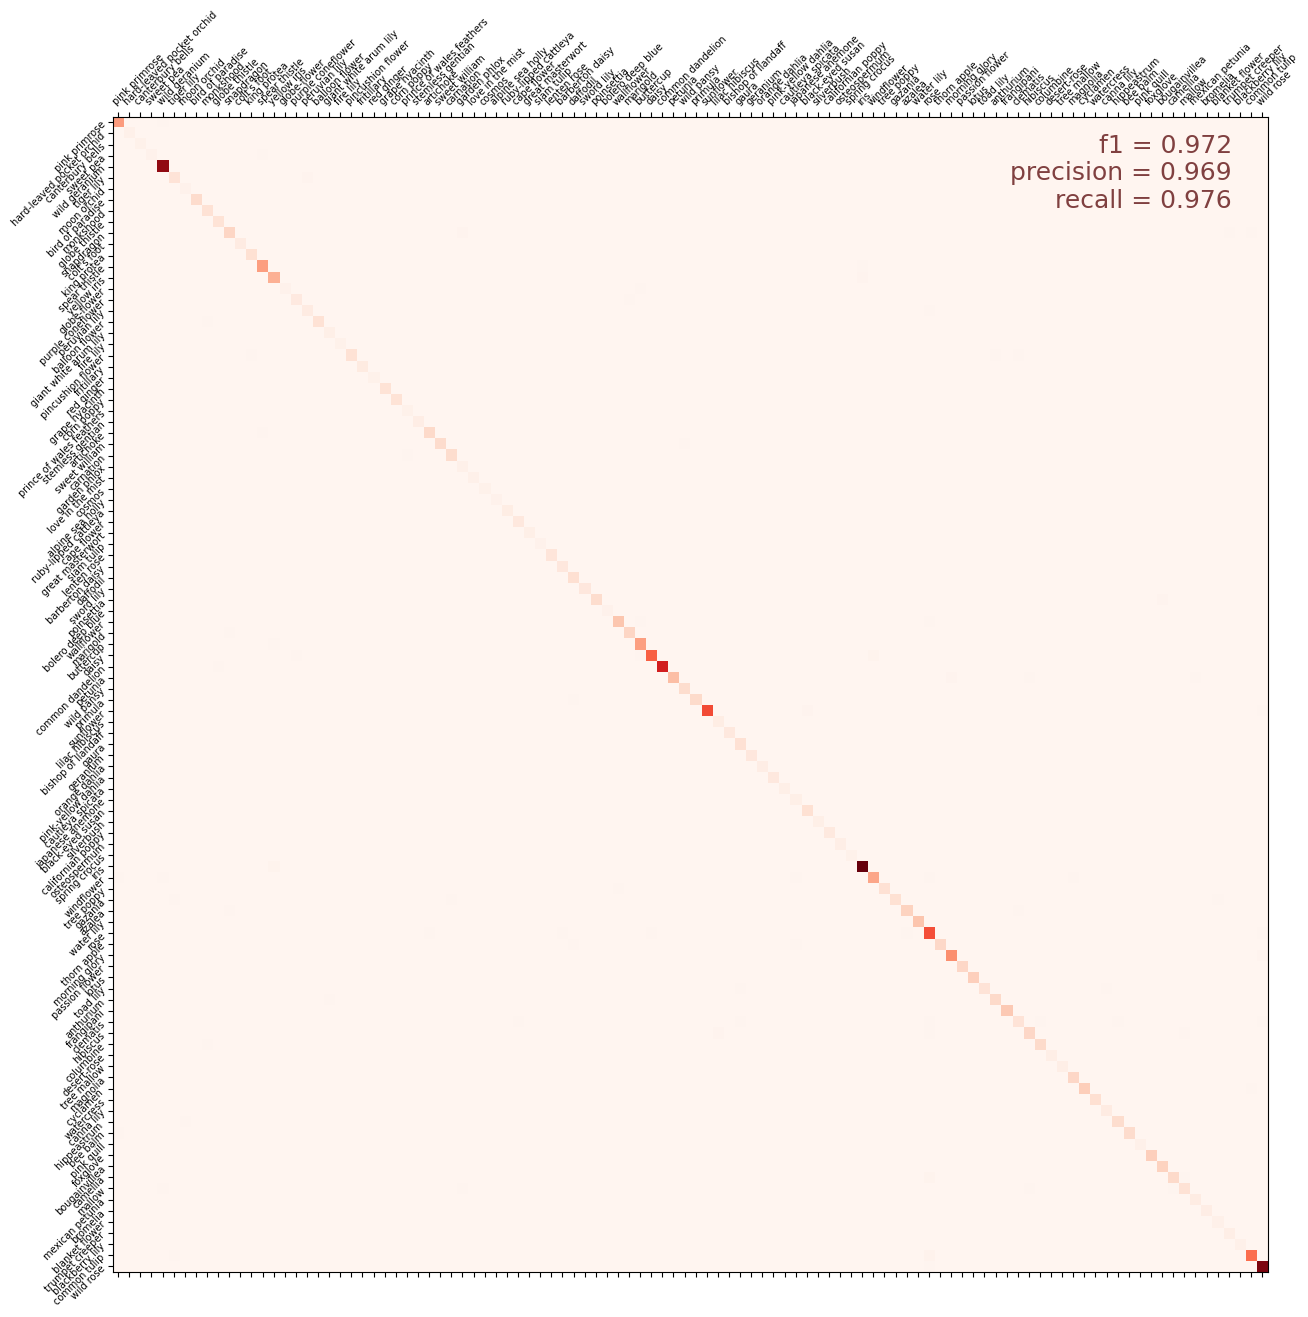

In [21]:
valid_ds = get_validation_dataset(ordered=True)
cm_predictions = predict(valid_ds, model)
cm_predictions = np.argmax(cm_predictions, axis=1)

labels_ds = valid_ds.map(lambda image, label: label).unbatch()
cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() # get everything as one batch

cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
#cmat = (cmat.T / cmat.sum(axis=1)).T # normalized
display_confusion_matrix(cmat, score, precision, recall)

Now we predict on the test dataset and write results to the submission file (submission.csv)

In [22]:
test_ds_1 = get_test_dataset(ordered=True, augmented=False)
preds_1 = predict(test_ds_1, model)

test_ds_2 = get_test_dataset(ordered=True, augmented=True)
preds_2 = predict(test_ds_2, model)

preds = (preds_1 + preds_2) / 2
preds = np.argmax(preds, axis=1)

print('Generating submission file...')
test_ids_ds = test_ds_1.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
                 
sub_df = pd.DataFrame({'id': test_ids, 'label': preds})
sub_df.to_csv('submission.csv', index=False)

Calculating predictions...
Calculating predictions...
Generating submission file...
